# Spherical harmonics visualisation

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm

from visualization.spherical_harmonics_visualization import plotAllHarmonicsUpToDegree
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion
from dataloader import loadhcp
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_cleaning import remove_b_0_measurements
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from sphericalharmonics.spherical_fourier_transform import get_spherical_fourier_transform
from sphericalharmonics.spherical_fourier_transform import get_design_matrix
from sphericalharmonics.spherical_fourier_transform import get_inverse_spherical_fourier_transform

## Visualisation of spherical harmonics up to degree 4

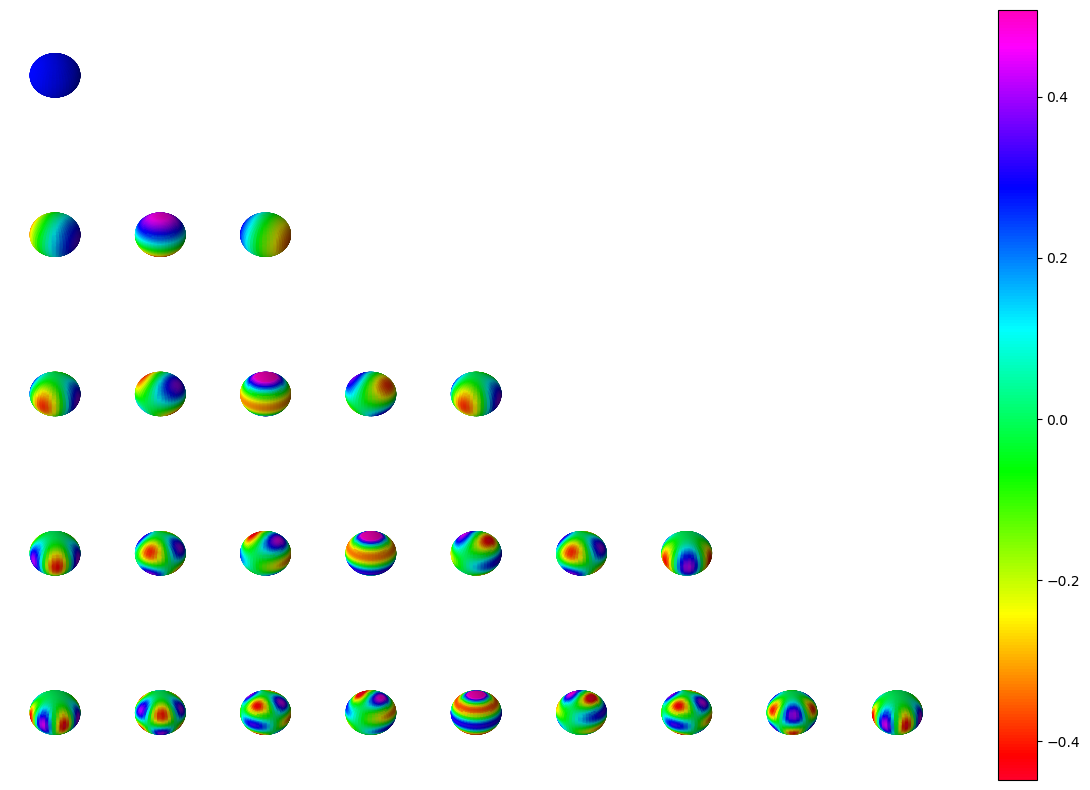

In [2]:
plotAllHarmonicsUpToDegree(4, resolution=50)

In [3]:
sph_harm(-1, 1, 0.0, np.pi/2).real

0.3454941494713355

In [4]:
sph_harm(1, 1, 0.0, np.pi/2).real

-0.3454941494713355

## Load dataset

In [5]:
bvals, qhat, dwis = loadhcp.load_hcp()

dwis.shape

(108, 145, 174, 145)

## Pre-processing

Remove $b=0$ measurements from the dataset.

In [6]:
bvals, qhat, dwis = remove_b_0_measurements(bvals, qhat, dwis)

Add reflections through the origin to the dataset

In [7]:
bvals, qhat, dwis = extend_dataset_with_origin_reflections(bvals, qhat, dwis)

Transform Cartesian coordinates to spherical

In [8]:
thetas, phis = convert_coords_from_cartesian_to_spherical(qhat)

## Pick a voxel (white matter)

In [9]:
voxel = dwis[:,100,75,71]

## Plot of how the signal reconstruction error depends on the maximum SH order

Compute the SH expansion coefficients for various values of maximum degree i.e. from $0$ to $15$ and the corresponding inverse transforms.

In [10]:
all_expansion_coefficients = []
all_inverse_spherical_fourier_transforms = []

all_design_matrices = []

# Determines the number of values used for the maximum degree
max_degree_upper_limit = 16

for max_degree in range(max_degree_upper_limit):
    design_matrix = get_design_matrix(max_degree = max_degree, number_of_samples=len(bvals), thetas=thetas, phis=phis)
    all_design_matrices.append(design_matrix)
    spherical_fourier_transform = get_spherical_fourier_transform(design_matrix)
    
    expansion_coefficients = spherical_fourier_transform @ voxel
    inverse_spherical_fourier_transform = get_inverse_spherical_fourier_transform(design_matrix)
    
    all_expansion_coefficients.append(expansion_coefficients)
    all_inverse_spherical_fourier_transforms.append(inverse_spherical_fourier_transform)

Use the inverse transforms to reconstruct the signals.

In [11]:
all_reconstructed_signals = []

for max_degree in range(max_degree_upper_limit):
    reconstructed_signal = all_inverse_spherical_fourier_transforms[max_degree] @ all_expansion_coefficients[max_degree]
    all_reconstructed_signals.append(reconstructed_signal)

Compute the differences between the original signals and the reconstructed signals

In [12]:
all_reconstruction_errors = []

for max_degree in range(max_degree_upper_limit):
    reconstruction_errors = voxel - all_reconstructed_signals[max_degree]
    all_reconstruction_errors.append(reconstruction_errors)

Compute the mean reconstruction error for each value of the maximum degree

In [13]:
all_mean_reconstruction_errors = []

for max_degree in range(max_degree_upper_limit):
    mean_reconstruction_error = np.mean(np.absolute(all_reconstruction_errors[max_degree]))
    all_mean_reconstruction_errors.append(mean_reconstruction_error)

In [14]:
all_mean_reconstruction_errors

[264.4082836914062,
 264.4082836914062,
 126.2159977986711,
 126.2159977986711,
 108.99118454152028,
 108.99118454152028,
 102.21202133163177,
 102.21202133163177,
 85.89462804391036,
 85.89462804391036,
 59.470201925798555,
 59.470201925798555,
 4.513999051091054e-12,
 4.513999051091054e-12,
 3.1529149661461513e-12,
 3.1529149661461513e-12]

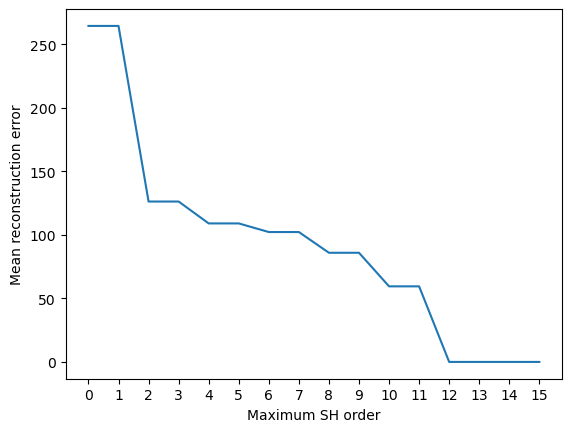

In [15]:
plt.plot(range(max_degree_upper_limit),all_mean_reconstruction_errors)
plt.xticks(range(max_degree_upper_limit))
plt.xlabel("Maximum SH order")
plt.ylabel("Mean reconstruction error")
plt.show()

## Plot the data from a single voxel and the corresponding spherical function.

In [16]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(121, projection="3d")
ax.scatter(qhat[0],qhat[1],qhat[2],c=voxel,vmin=1000,vmax=2000,cmap='viridis')
ax.set_axis_off()

x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(all_expansion_coefficients[10],10,resolution=50)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.viridis(fcolors), shade=False)
ax2.set_axis_off()

plt.show()